In [18]:
from jitcdde import t
from parameters import *
# from parameters_h_overall import *
from msrDynamics import Node, System
import pandas as pd
from are_model import build_are_model_base_hA

In [19]:
V_w_hxhwc

0.06512349397615365

In [20]:
# plotting style 
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "monospace"

# Set a professional color scheme
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
          'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

tls = 22
# Function to update the style of each axis
def update_axis_style(ax, title = '', x_label='', y_label='', x_ticks=True, y_scale='linear'):
    ax.set_title(title,fontsize=tls)
    ax.set_xlabel(x_label,fontsize=tls)
    ax.set_ylabel(y_label,fontsize=tls)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks,labelsize=tls)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True,labelsize=tls)
    ax.set_yscale(y_scale)

lw = 3

In [21]:
# unpack ORNL data 
df_power_reversed = pd.read_csv("./data/insertion.csv",header=None)
df_inlet_reversed = pd.read_csv("./data/fuel_inlet_temp.csv",header=None)
df_outlet_reversed = pd.read_csv("./data/fuel_outlet_temp.csv",header=None)
df_power = df_power_reversed.iloc[::-1] 
df_inlet = df_inlet_reversed.iloc[::-1]
df_outlet = df_outlet_reversed.iloc[::-1]
df_power = df_power.reset_index(drop=True)
df_inlet = df_inlet.reset_index(drop=True)
df_outlet = df_outlet.reset_index(drop=True)
df_inlet[1] = [F_to_K(t) for t in df_inlet[1]]
df_outlet[1] = [F_to_K(t) for t in df_outlet[1]]


# get indices for simulation data
t_before_data = (1110-df_inlet[0][0])*60
duration_data = (df_inlet.iloc[-1][0]-df_inlet[0][0])*60
t_end_data = df_inlet.iloc[-1][0]
t_before_sim = t_ins-t_before_data
T_insert = np.array([t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))])
i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]
adj = (df_inlet[0][0])*60-T_insert[0]
df_outlet = df_outlet[:-2]

# adjust to reported initial values (graphical interpretaion correction)
dp = df_power[1][0]-2.34
df_power[1] = [p-dp for p in df_power[1]]

dt_fin = df_inlet[1][0]-F_to_K(1217)
df_inlet[1] = [tf-dt_fin for tf in df_inlet[1]]

dt_fout = df_outlet[1][0]-F_to_K(1573)
df_outlet[1] = [tf-dt_fout for tf in df_outlet[1]]

# avg temp
ornl_diff = [df_outlet[1][i]-df_inlet[1][i] for i in range(len(df_inlet))]
ornl_avg = sum(ornl_diff)/len(ornl_diff)

In [22]:
from scipy.interpolate import interp1d

dT_fuel_correction = pd.read_csv('./data/dT_fuel_correction.csv',header=None)
dT_fuel_correction[0] *= 5/9  # convert from F to C
dT_fuel_correction[1] *= 5/9  # convert from F to C
dT_fuel_correction_interp = np.polyfit(dT_fuel_correction[0], dT_fuel_correction[1], 3)

df_inlet_correction = pd.read_csv('./data/inlet_correction.csv',header=None)
df_inlet_correction[0] = [F_to_K(t) for t in df_inlet_correction[0]]
df_inlet_correction[1] = [F_to_K(t) for t in df_inlet_correction[1]]
df_inlet_correction_interp = interp1d(df_inlet_correction[0], df_inlet_correction[1], fill_value="extrapolate")

df_outlet_correction = pd.read_csv('./data/outlet_correction.csv',header=None)
df_outlet_correction[0] = [F_to_K(t) for t in df_outlet_correction[0]]
df_outlet_correction[1] = [F_to_K(t) for t in df_outlet_correction[1]]
df_outlet_correction_interp = np.polyfit(df_outlet_correction[0], df_outlet_correction[1], 3)

In [23]:
params_fb_openmc = [-6.10e-05,  1.4e-05,  2.3e-05] 
# params_fb_estimation = [-6.08617335e-05,  1.4e-05,  2.25540322e-05] # estimation

# params_fb_estimation = [-4.81833507e-05,  2.03631125e-05,  2.63301128e-05]
# params_fb_estimation = [-3.54e-05, -2.22e-05,  6.33e-06]
params_fb_estimation = [-5.35e-05, 1.47e-05,  2.53e-05]

model_base = build_are_model_base_hA([a_f, a_b, a_c], force_eq = True)
model_openmc = build_are_model_base_hA(params_fb_openmc, force_eq = True)
model_estimation = build_are_model_base_hA(params_fb_estimation, force_eq = True)

In [24]:
# solve system 
sol_base = model_base.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)
sol_openmc = model_openmc.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)
sol_estimation = model_estimation.solve(T, populate_nodes = True, max_delay = tau_l, md_step = 0.0001)


finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress:   5%|▍         | 4565/100000 [00:08<00:44, 2167.16it/s]/home/luke/anaconda3/envs/onion_dynamics/lib/python3.12/site-packages/jitcdde/_jitcdde.py:1644: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  return super().integrate(target_time)[:self.input_base_n]
Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 11590.69it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 11920.52it/s]


populating nodes objects solution vectors...
finalizing integrator...
integrating...


Integration progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 100000/100000 [00:08<00:00, 12265.70it/s]


populating nodes objects solution vectors...


In [25]:
from scipy.interpolate import interp1d, CubicSpline
power_estimation = P*(sol_estimation[:,6]-1)
# power_interpolator = interp1d(df_power[0], df_power[1], fill_value="extrapolate")

adj = (df_power[0][0])*60-T_insert[0]
df_power[0] = [(t*60)-adj for t in df_power[0]]

# adjust to reported power
d = df_power[1][0]-P
df_power[1] = [p-d for p in df_power[1]]

# Set up interpolation
# Assuming df[0] is time and df[1] is the data you want to interpolate
spline = CubicSpline(df_power[0], df_power[1])  # Multiplying df[0] by 60 if it's in minutes

# Use the spline to interpolate at the desired times
interpolated_values = spline(T[i_insert])


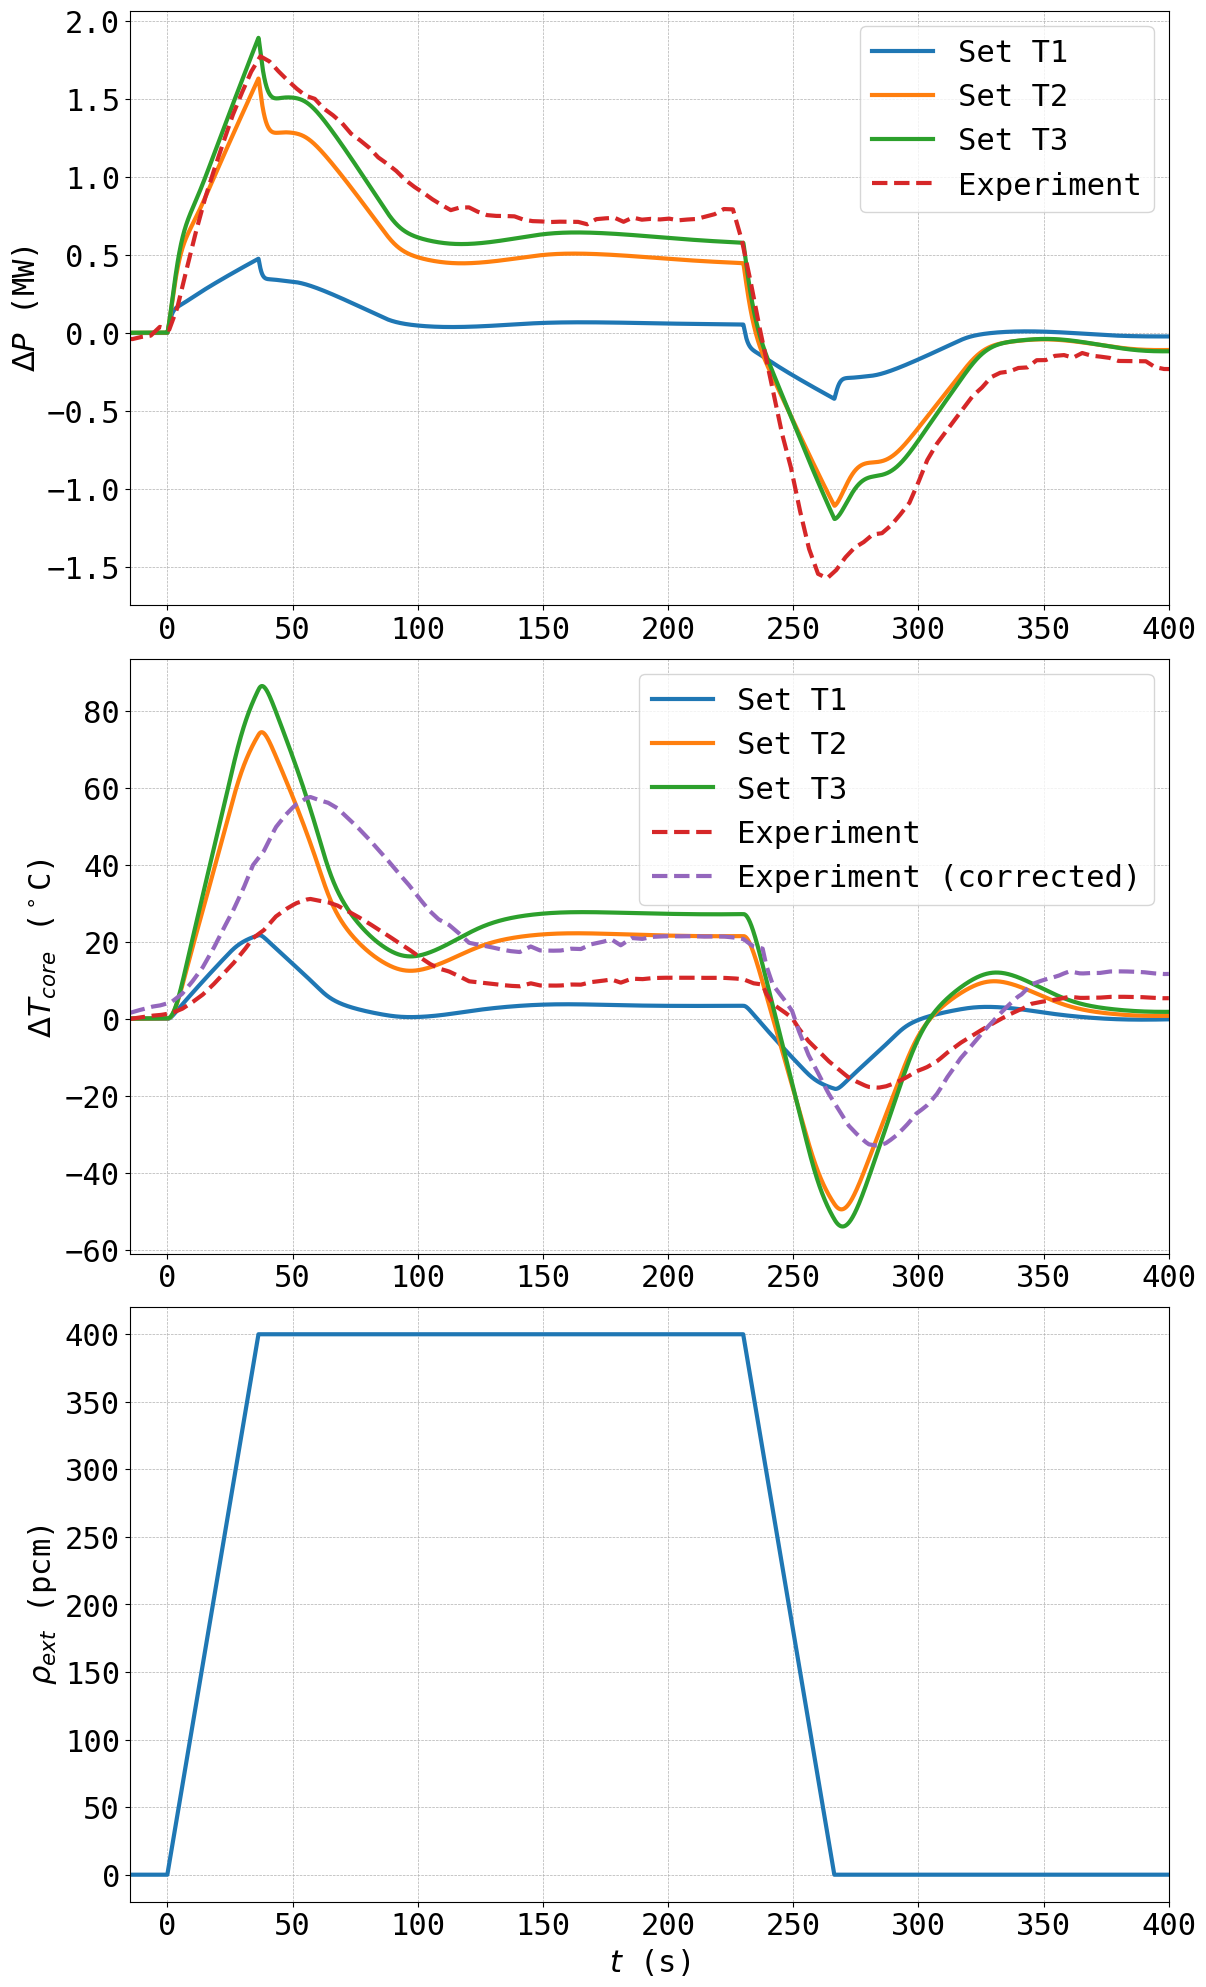

In [26]:
fig, axs = plt.subplots(3,1, figsize = (12,20), sharex = True)

t0, tf = -15.0, 400.0 
def rho_ext(t):
    if t <= t_ins:
        rho = 0.0
    elif t <= t_ins + insert_duration:
        rho = ((t-t_ins))*(11)
    elif t <= t_wd:
        rho = 400
    elif t <= t_wd + insert_duration:
        rho = 400 - (11)*(t-t_wd)
    else:
        rho = 0.0
    return rho*(1e-5) 

rho_dat = np.array([rho_ext(t) for t in T[T>=(300.0+t0)]])


update_axis_style(axs[0], None)
axs[0].plot(T_insert-t_ins,[P*(s-model_base.nodes['n'].y_out[i_insert[0]-1]) for s in model_base.nodes['n'].y_out[i_insert]],label="Set T1",color=colors[0],linewidth=lw)
axs[0].plot(T_insert-t_ins,[P*(s-model_openmc.nodes['n'].y_out[i_insert[0]-1]) for s in model_openmc.nodes['n'].y_out[i_insert]],label="Set T2",color=colors[1],linewidth=lw) 
axs[0].plot(T_insert-t_ins,[P*(s-model_estimation.nodes['n'].y_out[i_insert[0]-1]) for s in model_estimation.nodes['n'].y_out[i_insert]],label="Set T3",color=colors[2],linewidth=lw)
axs[0].plot(df_power[0]-t_ins,df_power[1]-df_power[1][0],label="Experiment",color=colors[3],linestyle='--',linewidth=lw)
axs[0].set_ylabel(r"$\Delta P$ (MW)")
# axs[0].set_xlim([t0,tf])
axs[0].legend(fontsize=tls)

df_inlet_interp = interp1d(df_inlet[0]*60-adj,df_inlet[1])
df_outlet_interp = interp1d(df_outlet[0]*60-adj,df_outlet[1])
interp_range = T_insert<710.039
corrected_outlet_data = np.polyval(df_outlet_correction_interp,df_outlet_interp(T_insert[interp_range]))
corrected_inlet_data = df_inlet_correction_interp(df_inlet_interp(T_insert[interp_range]))
dT_fuel_exp = (df_outlet_interp(T_insert[interp_range]) - df_inlet_interp(T_insert[interp_range])) - (df_outlet_interp(T_insert[interp_range])[0] - df_inlet_interp(T_insert[interp_range][0]))
# dT_fuel_corrected = corrected_outlet_data - corrected_inlet_data - (corrected_outlet_data[0] - corrected_inlet_data[0])
dT_fuel_corrected = np.polyval(dT_fuel_correction_interp, dT_fuel_exp)
update_axis_style(axs[1], None)
axs[1].plot(T_insert-t_ins,(model_base.nodes['c_f2'].y_out[i_insert]-model_base.nodes['hx_fh1_f2'].y_out[i_insert])-(model_base.nodes['c_f2'].y_out[i_insert][0]-model_base.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T1",color=colors[0],linewidth=lw)
axs[1].plot(T_insert-t_ins,(model_openmc.nodes['c_f2'].y_out[i_insert]-model_openmc.nodes['hx_fh1_f2'].y_out[i_insert])-(model_openmc.nodes['c_f2'].y_out[i_insert][0]-model_openmc.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T2",color=colors[1],linewidth=lw)
axs[1].plot(T_insert-t_ins,(model_estimation.nodes['c_f2'].y_out[i_insert]-model_estimation.nodes['hx_fh1_f2'].y_out[i_insert])-(model_estimation.nodes['c_f2'].y_out[i_insert][0]-model_estimation.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T3",color=colors[2],linewidth=lw)
axs[1].plot(T_insert[interp_range]-t_ins, dT_fuel_exp, label = "Experiment", color = colors[3], linewidth = lw, linestyle = '--')
axs[1].plot(T_insert[interp_range]-t_ins, dT_fuel_corrected, label = "Experiment (corrected)", color = colors[4], linewidth = lw, linestyle = '--')
axs[1].set_ylabel(r" $\Delta T_{core}$ ($^\circ$C)")
axs[1].set_xlim([t0,tf])
axs[1].legend(fontsize=tls)

update_axis_style(axs[2], None)
axs[2].plot(T[T>=(t_ins+t0)]-t_ins, rho_dat*(1e5), label=r'$\rho_{ext}$', linewidth=lw)
axs[2].set_xlim([t0,tf])
axs[2].set_ylabel(r"$\rho_{ext}$ (pcm)")
axs[2].set_xlabel(r"$t$ (s)")

fig.tight_layout()

fig.savefig('are_insert.png')

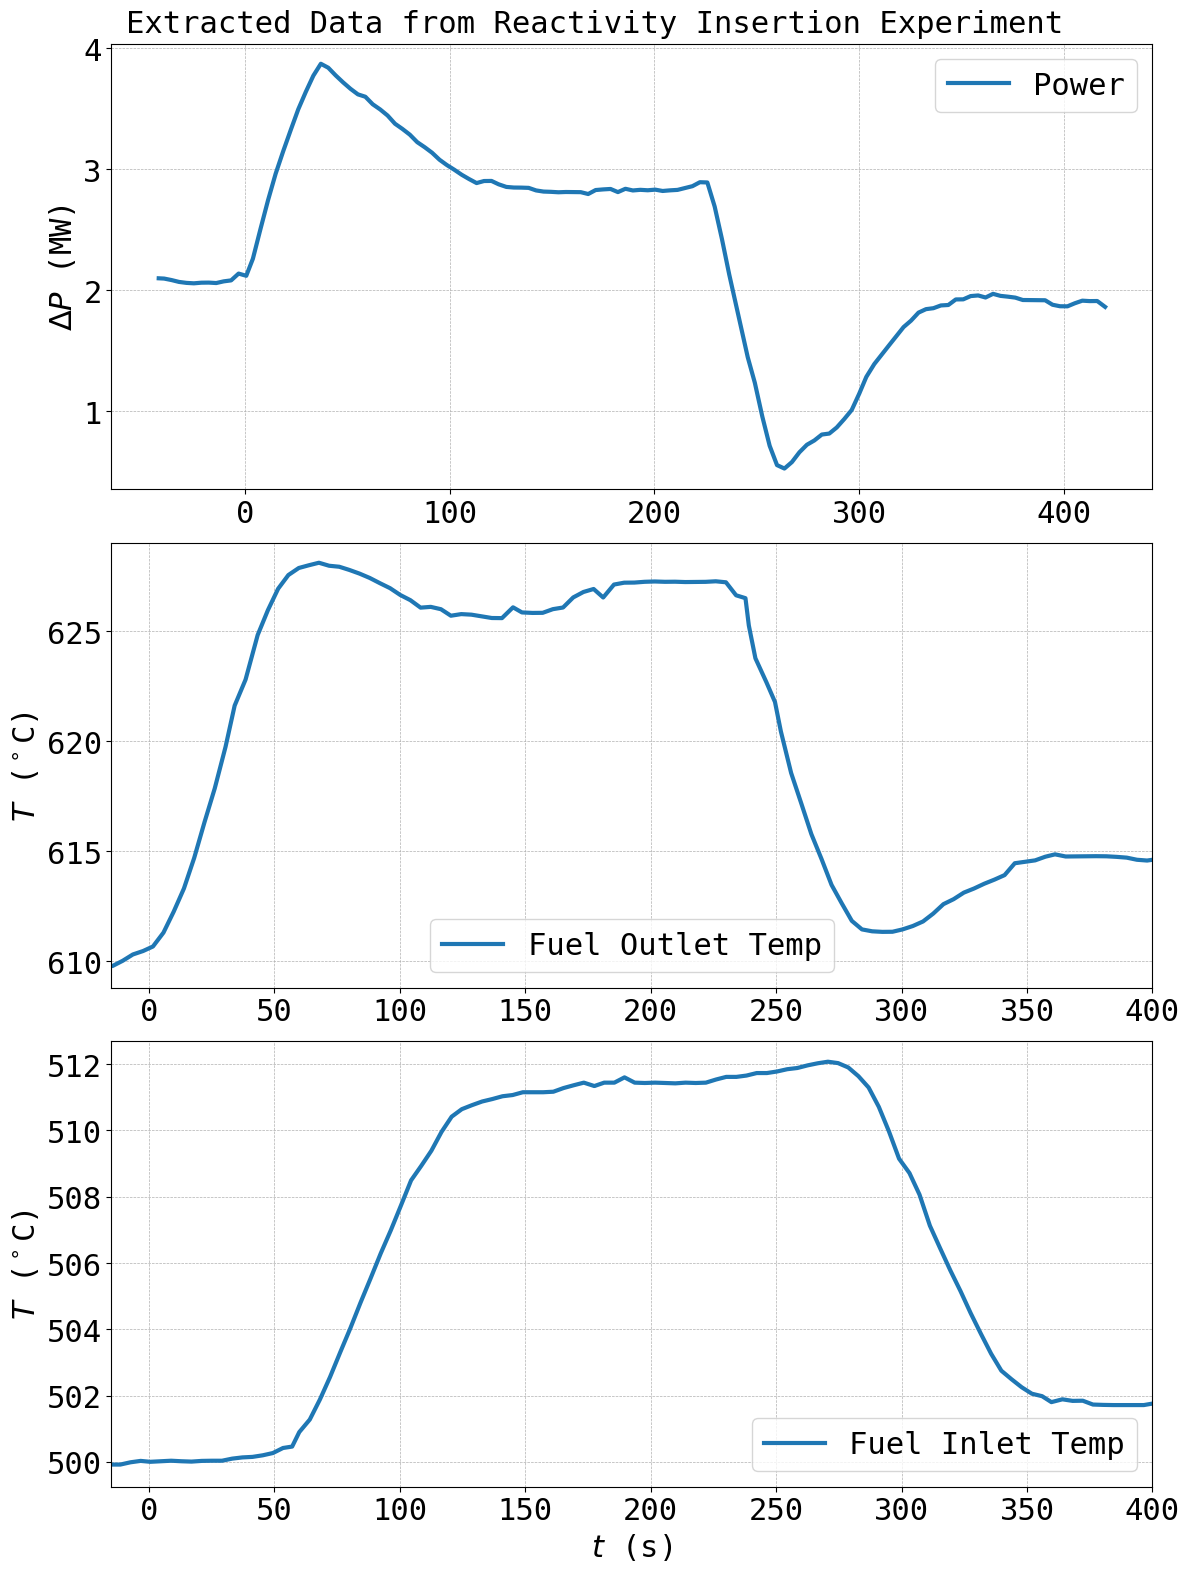

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(12, 16))

update_axis_style(axs[0], None)
axs[0].plot(df_power[0]-t_ins,df_power[1],label="Power", linewidth=lw)
axs[0].set_ylabel(r"$\Delta P$ (MW)")
# axs[0].set_xlim([t0,tf])
axs[0].legend(fontsize=tls)

update_axis_style(axs[1], None)
axs[1].plot(df_outlet[0]*60-adj-t_ins,F_to_K(df_outlet[1])-273,label="Fuel Outlet Temp", linewidth=lw)
axs[1].set_ylabel(r"$T$ ($^\circ$C)")
axs[1].set_xlim([t0,tf])    
axs[1].legend(fontsize=tls)

update_axis_style(axs[2], None)
axs[2].plot(df_inlet[0]*60-adj-t_ins,F_to_K(df_inlet[1])-273,label="Fuel Inlet Temp", linewidth=lw)
# xs[1].plot(df_outlet[0]*60-adj-t_ins,df_outlet[1],label="Fuel Outlet Temp")
axs[2].set_ylabel(r"$T$ ($^\circ$C)")
axs[2].set_xlim([t0,tf])
axs[2].legend(fontsize=tls)
axs[2].set_xlabel(r"$t$ (s)")

fig.suptitle("Extracted Data from Reactivity Insertion Experiment", fontsize=tls)
fig.tight_layout()



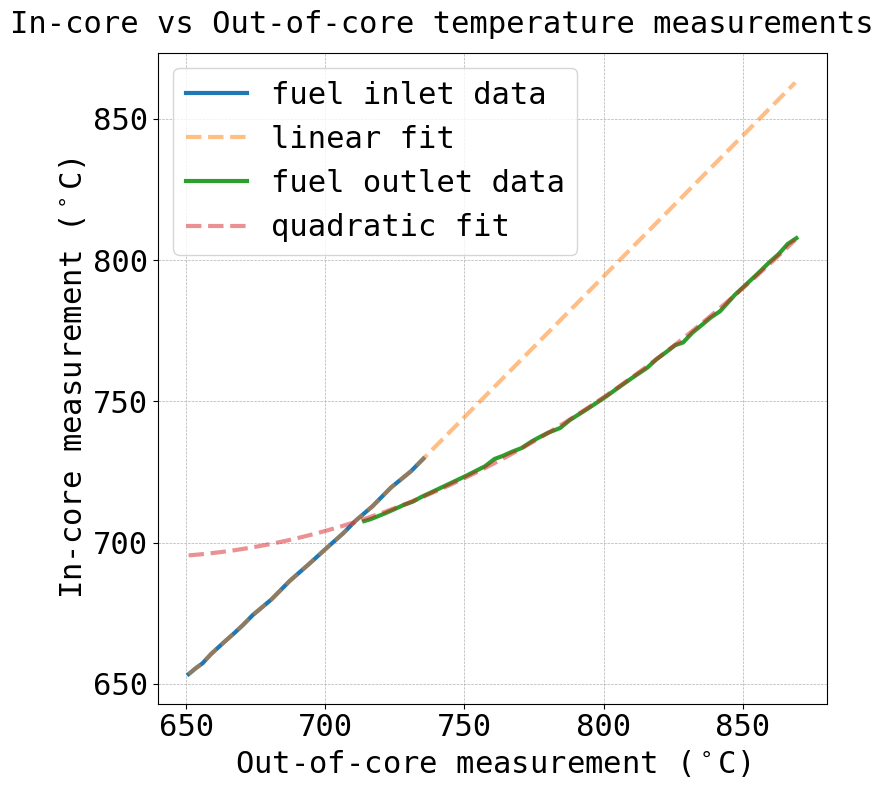

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

df_in_interp = interp1d(df_inlet_correction[1] -273, df_inlet_correction[0]-273, fill_value="extrapolate")
df_out_interp = np.polyfit(df_outlet_correction[1]-273, df_outlet_correction[0]-273, deg = 2)

range = np.arange(df_inlet_correction[1][0]-273,df_outlet_correction[1].iloc[-1]-273,1)
update_axis_style(axs, None)
axs.plot(df_inlet_correction[1] -273, df_inlet_correction[0]-273, label = 'fuel inlet data', linewidth=lw)
axs.plot(range, df_in_interp(range), label = 'linear fit', linestyle='--', alpha = 0.5, linewidth = lw)
axs.plot(df_outlet_correction[1]-273, df_outlet_correction[0]-273, label = 'fuel outlet data', linewidth=lw)
axs.plot(range, np.polyval(df_out_interp,range), label = 'quadratic fit', linestyle='--', alpha = 0.5, linewidth = lw)
axs.set_ylabel(r"In-core measurement ($^\circ$C)")
axs.set_xlabel(r"Out-of-core measurement ($^\circ$C)")
# axs.set_xlim([625,900])
# axs.set_ylim([650,825])
axs.legend(fontsize=tls)

fig.suptitle("In-core vs Out-of-core temperature measurements", fontsize=tls)
fig.tight_layout()

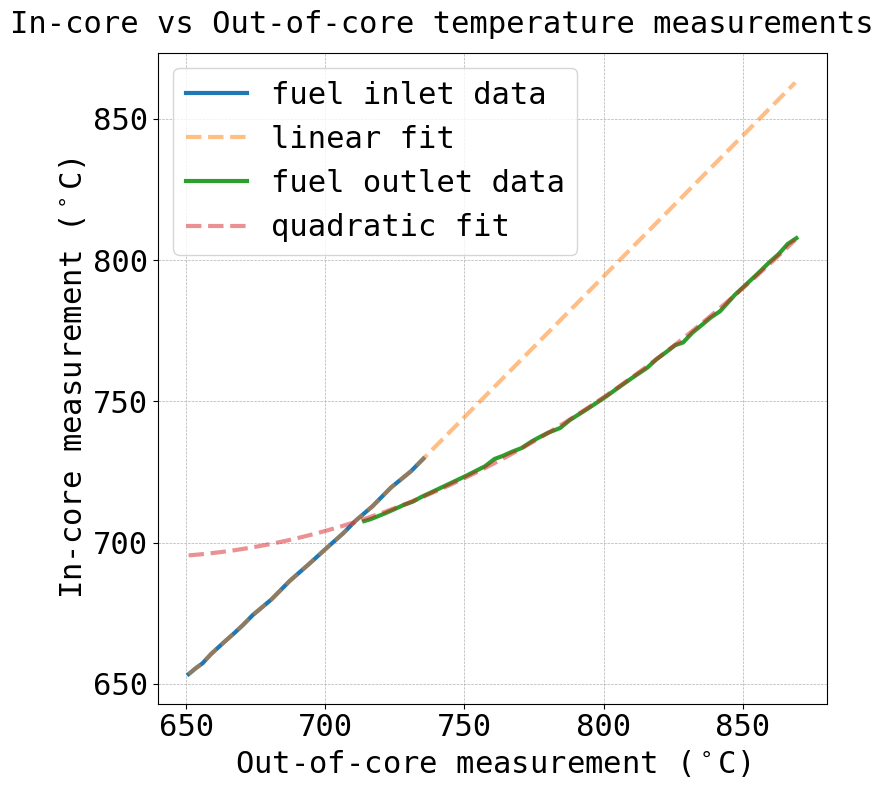

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

df_in_interp = interp1d(df_inlet_correction[1] -273, df_inlet_correction[0]-273, fill_value="extrapolate")
df_out_interp = np.polyfit(df_outlet_correction[1]-273, df_outlet_correction[0]-273, deg = 2)

range = np.arange(df_inlet_correction[1][0]-273,df_outlet_correction[1].iloc[-1]-273,1)
update_axis_style(axs, None)
axs.plot(df_inlet_correction[1] -273, df_inlet_correction[0]-273, label = 'fuel inlet data', linewidth=lw)
axs.plot(range, df_in_interp(range), label = 'linear fit', linestyle='--', alpha = 0.5, linewidth = lw)
axs.plot(df_outlet_correction[1]-273, df_outlet_correction[0]-273, label = 'fuel outlet data', linewidth=lw)
axs.plot(range, np.polyval(df_out_interp,range), label = 'quadratic fit', linestyle='--', alpha = 0.5, linewidth = lw)
axs.set_ylabel(r"In-core measurement ($^\circ$C)")
axs.set_xlabel(r"Out-of-core measurement ($^\circ$C)")
# axs.set_xlim([625,900])
# axs.set_ylim([650,825])
axs.legend(fontsize=tls)

fig.suptitle("In-core vs Out-of-core temperature measurements", fontsize=tls)
fig.tight_layout()

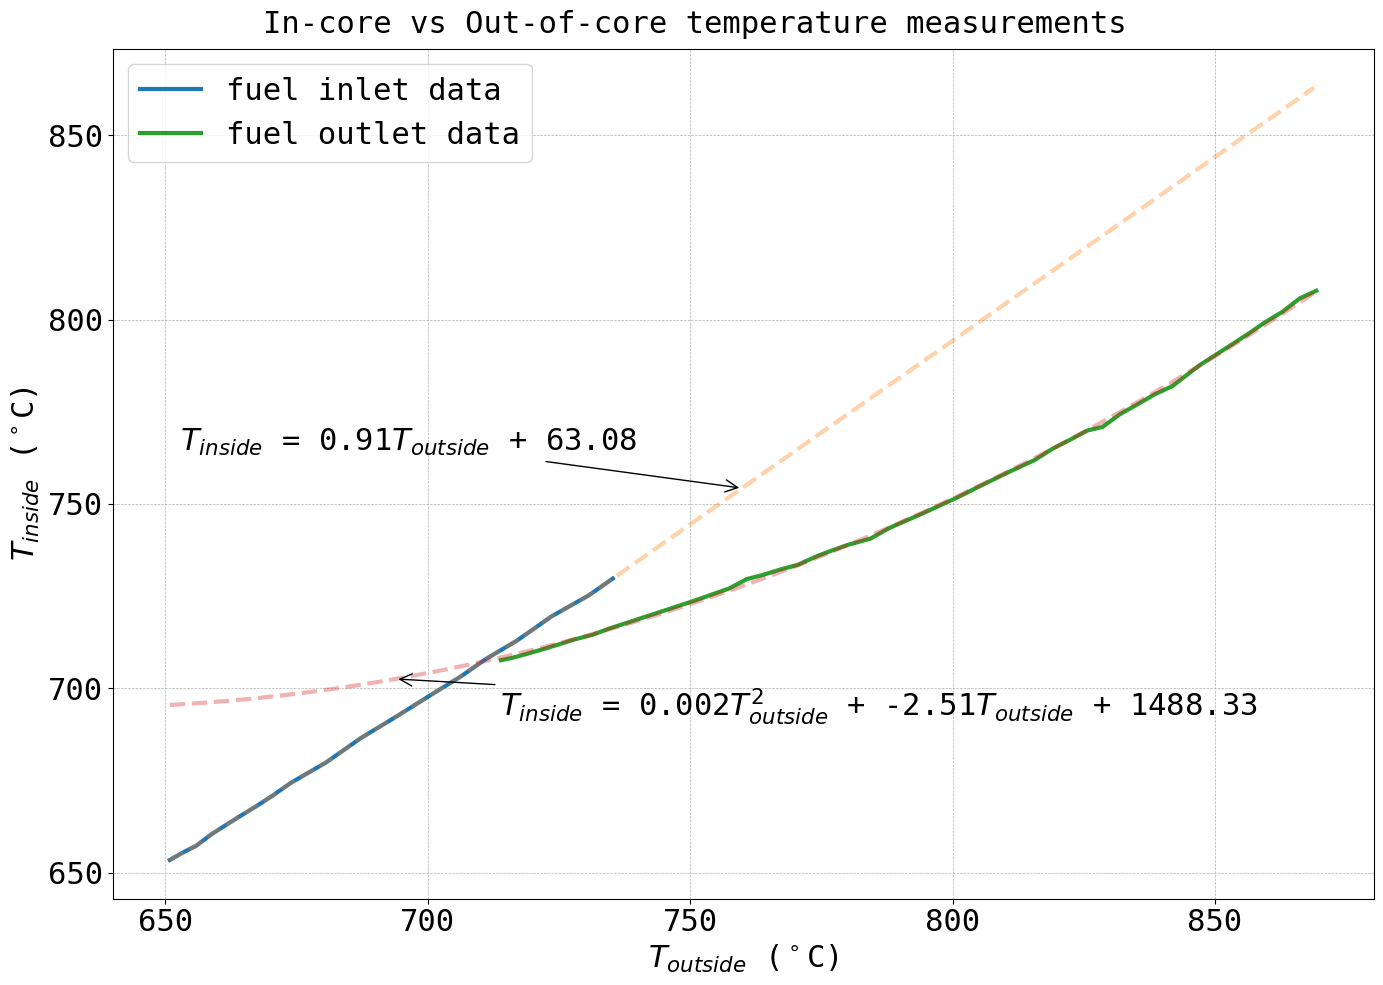

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(14, 10))

df_in_interp = interp1d(df_inlet_correction[1] -273, df_inlet_correction[0]-273, fill_value="extrapolate")
df_out_interp = np.polyfit(df_outlet_correction[1]-273, df_outlet_correction[0]-273, deg=2)

range = np.arange(df_inlet_correction[1][0]-273, df_outlet_correction[1].iloc[-1]-273, 1)
update_axis_style(axs, None)
axs.plot(df_inlet_correction[1] -273, df_inlet_correction[0]-273, label='fuel inlet data', linewidth=lw)
axs.plot(range, df_in_interp(range), linestyle='--', alpha=0.35, linewidth=lw)
axs.plot(df_outlet_correction[1]-273, df_outlet_correction[0]-273, label='fuel outlet data', linewidth=lw)
axs.plot(range, np.polyval(df_out_interp, range), linestyle='--', alpha=0.35, linewidth=lw)
axs.set_ylabel(r"$T_{inside}$ ($^\circ$C)")
axs.set_xlabel(r"$T_{outside}$ ($^\circ$C)")

# Add equation labels with pointers
# For linear fit, we need to calculate slope and intercept manually
x_in = df_inlet_correction[1] - 273
y_in = df_inlet_correction[0] - 273
slope, intercept = np.polyfit(x_in, y_in, 1)
linear_eq = f"$T_{{inside}}$ = {slope:.2f}$T_{{outside}}$ + {intercept:.2f}"

# For quadratic fit
quad_coeffs = np.poly1d(df_out_interp)
quad_eq = f"$T_{{inside}}$ = {quad_coeffs.c[0]:.2g}$T_{{outside}}^2$ + {quad_coeffs.c[1]:.2f}$T_{{outside}}$ + {quad_coeffs.c[2]:.2f}"

# Choose points for the annotations (adjust as needed)
linear_point = (range[len(range)//2], df_in_interp(range[len(range)//2]))
quad_point = (range[2*len(range)//10], np.polyval(df_out_interp, range[2*len(range)//10]))

axs.annotate(linear_eq, xy=linear_point, xytext=(linear_point[0]-20, linear_point[1]+10),
            arrowprops=dict(arrowstyle="->"), ha='right', fontsize = 22)
axs.annotate(quad_eq, xy=quad_point, xytext=(quad_point[0]+20, quad_point[1]-10),
            arrowprops=dict(arrowstyle="->"), ha='left',fontsize = 22)

axs.legend(fontsize=tls)
fig.suptitle("In-core vs Out-of-core temperature measurements", fontsize=tls)
fig.tight_layout()

In [31]:
df_outlet_correction[1].iloc[-1]-273

np.float64(869.3118655130729)

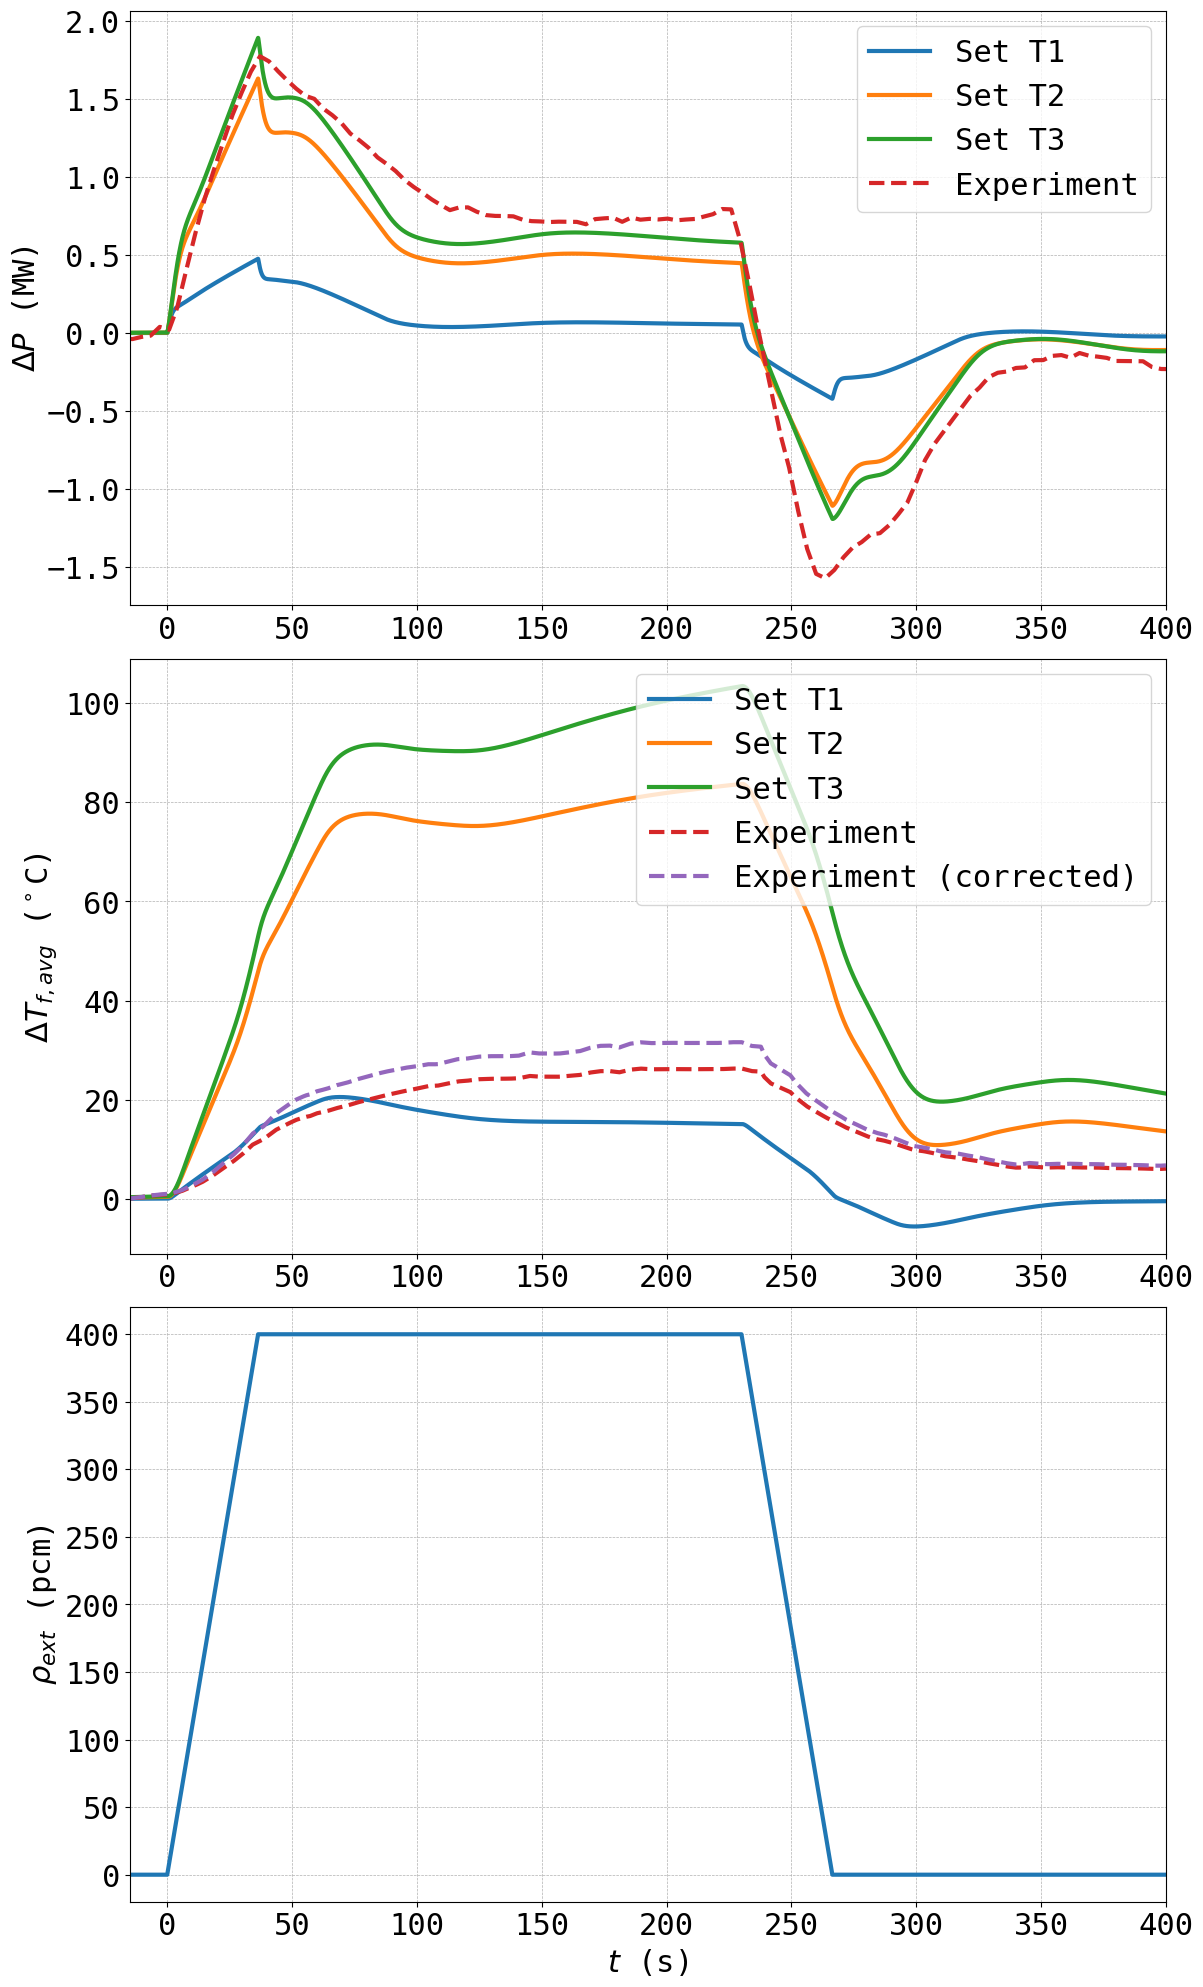

In [32]:
fig, axs = plt.subplots(3,1, figsize = (12,20), sharex = True)

t0, tf = -15.0, 400.0 
def rho_ext(t):
    if t <= t_ins:
        rho = 0.0
    elif t <= t_ins + insert_duration:
        rho = ((t-t_ins))*(11)
    elif t <= t_wd:
        rho = 400
    elif t <= t_wd + insert_duration:
        rho = 400 - (11)*(t-t_wd)
    else:
        rho = 0.0
    return rho*(1e-5) 

rho_dat = np.array([rho_ext(t) for t in T[T>=(300.0+t0)]])


update_axis_style(axs[0], None)
axs[0].plot(T_insert-t_ins,[P*(s-model_base.nodes['n'].y_out[i_insert[0]-1]) for s in model_base.nodes['n'].y_out[i_insert]],label="Set T1",color=colors[0],linewidth=lw)
axs[0].plot(T_insert-t_ins,[P*(s-model_openmc.nodes['n'].y_out[i_insert[0]-1]) for s in model_openmc.nodes['n'].y_out[i_insert]],label="Set T2",color=colors[1],linewidth=lw) 
axs[0].plot(T_insert-t_ins,[P*(s-model_estimation.nodes['n'].y_out[i_insert[0]-1]) for s in model_estimation.nodes['n'].y_out[i_insert]],label="Set T3",color=colors[2],linewidth=lw)
axs[0].plot(df_power[0]-t_ins,df_power[1]-df_power[1][0],label="Experiment",color=colors[3],linestyle='--',linewidth=lw)
axs[0].set_ylabel(r"$\Delta P$ (MW)")
# axs[0].set_xlim([t0,tf])
axs[0].legend(fontsize=tls)

# df_inlet_interp = interp1d(df_inlet[0]*60-adj,df_inlet[1])
# df_outlet_interp = interp1d(df_outlet[0]*60-adj,df_outlet[1])
# interp_range = T_insert<710.039
# # corrected_outlet_data = np.polyval(df_outlet_correction_interp,df_outlet_interp(T_insert[interp_range]))
# # corrected_inlet_data = df_inlet_correction_interp(df_inlet_interp(T_insert[interp_range]))
# dT_fuel_exp = (df_outlet_interp(T_insert[interp_range]) - df_inlet_interp(T_insert[interp_range])) - (df_outlet_interp(T_insert[interp_range])[0] - df_inlet_interp(T_insert[interp_range][0]))
# dT_fuel_corrected = np.polyval(dT_fuel_correction_interp, dT_fuel_exp)
# update_axis_style(axs[1], None)
# axs[1].plot(T_insert-t_ins,(model_base.nodes['c_f2'].y_out[i_insert]-model_base.nodes['hx_fh1_f2'].y_out[i_insert])-(model_base.nodes['c_f2'].y_out[i_insert][0]-model_base.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T1",color=colors[0],linewidth=lw)
# axs[1].plot(T_insert-t_ins,(model_openmc.nodes['c_f2'].y_out[i_insert]-model_openmc.nodes['hx_fh1_f2'].y_out[i_insert])-(model_openmc.nodes['c_f2'].y_out[i_insert][0]-model_openmc.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T2",color=colors[1],linewidth=lw)
# axs[1].plot(T_insert-t_ins,(model_estimation.nodes['c_f2'].y_out[i_insert]-model_estimation.nodes['hx_fh1_f2'].y_out[i_insert])-(model_estimation.nodes['c_f2'].y_out[i_insert][0]-model_estimation.nodes['hx_fh1_f2'].y_out[i_insert][0]),label="Set T3",color=colors[2],linewidth=lw)
# axs[1].plot(T_insert[interp_range]-t_ins, dT_fuel_exp, label = "Experiment", color = colors[3], linewidth = lw, linestyle = '--')
# axs[1].plot(T_insert[interp_range]-t_ins, dT_fuel_corrected, label = "Experiment (corrected)", color = colors[4], linewidth = lw, linestyle = '--')
# axs[1].set_ylabel(r" $\Delta T_{core}$ ($^\circ$C)")
# axs[1].set_xlim([t0,tf])
# axs[1].legend(fontsize=tls)

update_axis_style(axs[1], None)
T_f_base = (model_base.nodes['c_f2'].y_out[i_insert]+model_base.nodes['hx_fh1_f2'].y_out[i_insert])/2 
T_f_openmc = (model_openmc.nodes['c_f2'].y_out[i_insert]+model_openmc.nodes['hx_fh1_f2'].y_out[i_insert])/2
T_f_estimation = (model_estimation.nodes['c_f2'].y_out[i_insert]+model_estimation.nodes['hx_fh1_f2'].y_out[i_insert])/2
T_f_experiment = (df_outlet_interp(T_insert[interp_range]) + df_inlet_interp(T_insert[interp_range]))/2
T_f_experiment_corrected = (np.polyval(df_outlet_correction_interp, df_outlet_interp(T_insert[interp_range])) + df_inlet_correction_interp(df_inlet_interp(T_insert[interp_range])))/2
dT_f_experiment_corrected = T_f_experiment_corrected - T_f_experiment_corrected[0]
axs[1].plot(T_insert-t_ins,T_f_base - T_f_base[0],label="Set T1",color=colors[0],linewidth=lw)
axs[1].plot(T_insert-t_ins,T_f_openmc - T_f_openmc[0],label="Set T2",color=colors[1],linewidth=lw)
axs[1].plot(T_insert-t_ins,T_f_estimation - T_f_estimation[0],label="Set T3",color=colors[2],linewidth=lw)
axs[1].plot(T_insert[interp_range]-t_ins, T_f_experiment - T_f_experiment[0], label = "Experiment", color = colors[3], linewidth = lw, linestyle = '--')
axs[1].plot(T_insert[interp_range]-t_ins, dT_f_experiment_corrected, label = "Experiment (corrected)", color = colors[4], linewidth = lw, linestyle = '--')
axs[1].set_ylabel(r" $\Delta T_{f,avg}$ ($^\circ$C)")
axs[1].set_xlim([t0,tf])
axs[1].legend(fontsize=tls)

update_axis_style(axs[2], None)
axs[2].plot(T[T>=(t_ins+t0)]-t_ins, rho_dat*(1e5), label=r'$\rho_{ext}$', linewidth=lw)
axs[2].set_xlim([t0,tf])
axs[2].set_ylabel(r"$\rho_{ext}$ (pcm)")
axs[2].set_xlabel(r"$t$ (s)")

fig.tight_layout()

fig.savefig('are_insert.png')